TEMPERATURE PREDICTION USING BIDIRECTIONAL LSTM

In [3]:
# Importing library to read the temperature data
import pandas as pd

In [4]:
# Reading the Dataset
#df=pd.read_csv('/kaggle/input/dataset/testset.csv')
df=pd.read_csv('./dataset/testset.csv')

In [5]:
# A view at the dataset
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [6]:
len(df)

100990

In [7]:
# Generating dataframe with temp column and datetime_utc as index
data = pd.DataFrame(list(df[' _tempm']), index=df['datetime_utc'], columns=['temp'])

In [8]:
# A view at the dataframe
data

,temp
datetime_utc,
19961101-11:00,30.0
19961101-12:00,28.0
19961101-13:00,24.0
19961101-14:00,24.0
19961101-16:00,23.0
...,...
20170424-06:00,34.0
20170424-09:00,38.0
20170424-12:00,36.0


In [9]:
data.shape

(100990, 1)

In [10]:
data.isnull().sum()

temp    673
dtype: int64

In [11]:
# Getting rid of null data
df=data.dropna(axis=0)

In [12]:
df.shape

(100317, 1)

In [13]:
df=df['temp'].values

In [14]:
# Transforming df for scaling
df=df.reshape(-1,1)

In [15]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

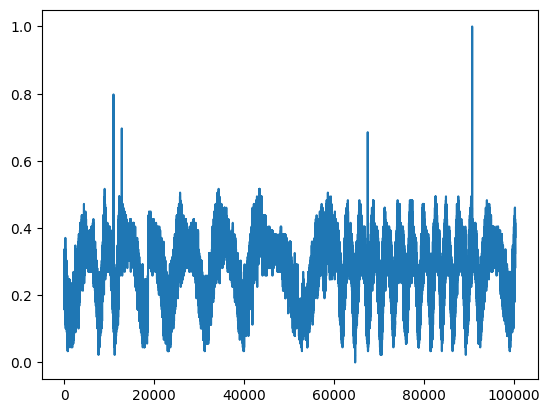

In [16]:
# Plotting the scaled data
import matplotlib.pyplot as plt
plt.plot(data_scaled)

In [17]:
##splitting dataset into train and test split
training_size=int(len(data_scaled)*0.75)
test_size=len(data_scaled)-training_size
train_data,test_data=data_scaled[0:training_size,:],data_scaled[training_size:len(data_scaled),:1]

In [18]:
training_size,test_size

(75237, 25080)

In [19]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [20]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
print(X_train.shape), print(y_train.shape)

(75136, 100)
(75136,)


(None, None)

In [22]:
print(X_test.shape), print(ytest.shape)

(24979, 100)
(24979,)


(None, None)

In [23]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [24]:

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


2025-06-18 17:26:53.796936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750267613.982310      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750267614.034899      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750267626.779605      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750267626.780425      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 100, 64)             │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,905 (140.25 KB)

 Trainable params: 35,777 (139.75 KB)

 Non-trainable params: 128 (512.00 B)

In [25]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/20


I0000 00:00:1750267635.158896      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 0.0210 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0018 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0013 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0011 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 9.7268e-04 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 8.6342e-04 - val_loss: 0.0030 - learning_rate: 5.0000e-04
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 8.4460e-04 - val_loss: 0.0030 - learning_rate: 5.0000e-04


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 100, 64)             │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,461 (419.77 KB)

 Trainable params: 35,777 (139.75 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 71,556 (279.52 KB)

In [27]:
from keras.callbacks import ModelCheckpoint

In [28]:
# Filepath to save the best model with epoch and val_loss
filepath = './my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [32]:
# adding model checkpoint to monitor the val_loss and save the best model based on minimum val_loss to filepath
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath="best_model.keras",     # Simple filename
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)


In [33]:
# Setting callbacks as checkpoint
callbacks = [checkpoint]

In [34]:
# Fitting the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=5,batch_size=64,verbose=1,callbacks=callbacks)

Epoch 1/5
1172/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
Epoch 1: val_loss improved from inf to 0.00217, saving model to best_model.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 2/5
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014
Epoch 2: val_loss improved from 0.00217 to 0.00143, saving model to best_model.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/5
1172/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011
Epoch 3: val_loss did not improve from 0.00143
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0010
Epoch 4: val_loss improved from 0.00143 to 0.00101, saving model to best_model.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 5/5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.5078e-04
Epoch 5: val_loss did not improve fro

In [35]:
# Comparing a random predicted value with the expected one
print("Predicted Value",model.predict(X_train)[4][0])
print("Expected value",y_train[4])

2348/2348 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step
Predicted Value 0.24973026
Expected value 0.2696629213483146


In [36]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

2348/2348 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


In [37]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [38]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

25.79951890191799

In [39]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

25.55200248696203

In [40]:
import numpy as np

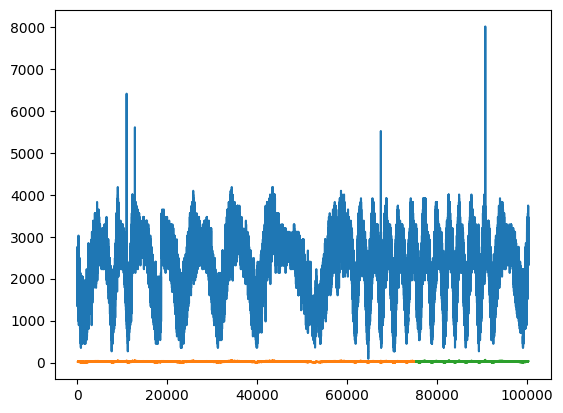

In [41]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [42]:
len(test_data)

25080

In [43]:
x_input=test_data[24715:].reshape(1,-1)
x_input.shape

(1, 365)

In [44]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [46]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=365
i=0
while(i<30):
    
    if(len(temp_input)>365):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.31460674 0.30337079 0.23595506 0.20224719 0.17977528 0.17977528
 0.21348315 0.2247191  0.25842697 0.26966292 0.26966292 0.29213483
 0.29213483 0.29213483 0.31460674 0.31460674 0.3258427  0.31460674
 0.30337079 0.28089888 0.24719101 0.21348315 0.17977528 0.17977528
 0.20224719 0.26966292 0.30337079 0.3258427  0.31460674 0.25842697
 0.21348315 0.19101124 0.17977528 0.23595506 0.3258427  0.35955056
 0.34831461 0.26966292 0.2247191  0.21348315 0.21348315 0.24719101
 0.35955056 0.38202247 0.37078652 0.29213483 0.25842697 0.23595506
 0.21348315 0.24719101 0.35955056 0.40449438 0.38202247 0.30337079
 0.26966292 0.24719101 0.2247191  0.26966292 0.31460674 0.33707865
 0.34831461 0.35955056 0.37078652 0.37078652 0.35955056 0.29213483
 0.26966292 0.24719101 0.20224719 0.23595506 0.33707865 0.37078652
 0.34831461 0.29213483 0.26966292 0.23595506 0.2247191  0.24719101
 0.35955056 0.38202247 0.38202247 0.35955056 0.33707865 0.31460674
 0.28089888 0.26966292 0.24719101 0.26966292 0.359

In [47]:
df2=df.tolist()
df2.extend(lst_output)


In [48]:
# Transforming back to original form
df3=scaler.inverse_transform(df2).tolist()

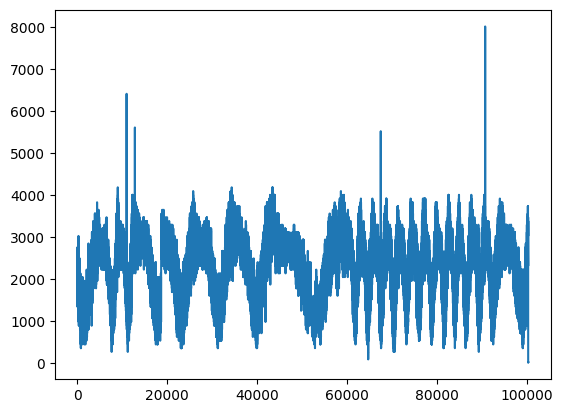

In [49]:
# Plotting the predicted temperature
plt.plot(df3)